======================================================================================================

**Disclaimer**: Parts of this notebook are adapted from this [**Open Source Notebook**](https://github.com/DeepRLCourse/Workshop-3-Material/blob/main/Workshop3_Notebook.ipynb)  with minor modifications. Credit to the original authors.

======================================================================================================

# Workshop 4

## Implementation REINFORCE Algorithm in CartPole-v1

## Setup

All required packages are pre-installed if using Google Colab.


Import the following libraries.

In [2]:
# Imports
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
import gym
import matplotlib
import matplotlib.pyplot as plt
import base64
import imageio
import IPython
import logging
import warnings

# Disable warnings
logging.getLogger().setLevel(logging.ERROR)
warnings.filterwarnings('ignore', category=DeprecationWarning)

# DEVICE
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda')

In [24]:
import numpy as np
print(np.__version__)  # If it's 1.24 or higher, you might want to downgrade
!pip install numpy==1.23.5

2.0.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 108.7 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jax 0.5.2 requires numpy>=1.25, but you have numpy 1.23.5 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.23.5 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.23.5 which is incompatible.
pymc 5.22.0 requires numpy>=1.25.0, but you have numpy 1.23.5 which is incompatible.
db-dtypes 1.4.3 requires numpy>=1.24.0, but you have numpy 1.23.5 which is incompatible.
chex 0.1.89 requires numpy>=1.24.1, but you have numpy 1.23.5 which is incompatible.
albumentations 2.0.6 requires numpy>=1.24.4, but you have numpy 1.23.5 

Configure Matplotlib for Interactive and XKCD-Style Plots

In [3]:
# Set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
plt.ion()
plt.xkcd(scale=1, length=100, randomness=2)
matplotlib.rcParams['figure.figsize'] = (12, 6)

Record and Embed Simulation Videos in Jupyter Notebook

<b>embed_mp4:</b> Converts an MP4 video into a base64-encoded HTML tag for display in Jupyter Notebook.
<br>
<b>record_simulation:</b> Runs a policy in the environment, records the simulation, and saves it as an MP4 video.

In [4]:
def embed_mp4(filename):
    video = open(filename,'rb').read()
    b64 = base64.b64encode(video)
    tag = '''
    <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
    Your browser does not support the video tag.
    </video>'''.format(b64.decode())
    return IPython.display.HTML(tag)

def record_simulation(env, policy_net, filename, episodes=1, fps=30):
    filename = filename + ".mp4"
    with imageio.get_writer(filename, fps=fps) as video:
        for _ in range(episodes):
            state = env.reset()
            frame = env.render()  # Capture the first frame
            video.append_data(frame[0])

            done = False
            while not done:
                state_tensor = torch.FloatTensor(state).to(DEVICE)
                action = torch.argmax(policy_net(state_tensor)).item()
                state, _, terminated, truncated, _ = env.step(action)

                frame = env.render()  # Capture the frame after taking the action
                video.append_data(frame[0])

                done = terminated or truncated
    return embed_mp4(filename)

## Explore the environment

Initialize CartPole Environment and Display State & Action Spaces

In [5]:
# Create the CartPole environment
env = gym.make("CartPole-v1")

# Print observation and action space
print("Observation Space:", env.observation_space)
print("Action Space:", env.action_space)

Observation Space: Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
Action Space: Discrete(2)


Define a Random Policy for Action Selection  

In [6]:
class RandomPolicy(object):

    def __init__(self, action_space_n):
        self.action_space_n = action_space_n

    def __call__(self, state):
        action_values = torch.rand(self.action_space_n)
        return action_values

Visualize the random policy.

In [10]:
random_policy = RandomPolicy(env.action_space.n)

record_simulation(gym.make("CartPole-v1", render_mode='rgb_array', new_step_api=True), random_policy, "Video_CartPole_random_policy")

## Agent with REINFORCE Algorithm in CartPole-v1


### Policy Network Definition

In [11]:
# Policy Network
class Policy(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=-1)
        return x

### Hyperparameters

In [12]:
# Hyperparameters
learning_rate = 0.001
gamma = 0.99
episodes = 2000

### Environment

In [13]:
# Environment setup
env = gym.make('CartPole-v1')
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

### Initialization

In [18]:
# Initialize policy and optimizer
policy = Policy(state_dim,action_dim)
optimizer = optim.Adam(policy.parameters(), lr=learning_rate)

### Choose action

In [19]:
# Function to choose action based on policy
def choose_action(state):
    state = torch.from_numpy(state).float().unsqueeze(0)
    probs = policy(state)
    m = Categorical(probs)
    action = m.sample()
    return action.item(), m.log_prob(action)

### Training

In [20]:
def run_episode(env):
    """Run a single episode and return states, actions, rewards, and log probabilities."""
    state = env.reset()
    rewards = []
    log_probs = []

    while True:
        action, log_prob = choose_action(state)
        next_state, reward, done, _ = env.step(action)

        rewards.append(reward)
        log_probs.append(log_prob)
        state = next_state

        if done:
            break

    return rewards, log_probs

def calculate_discounted_rewards(rewards, gamma):
    """Calculate and normalize discounted rewards."""
    discounted_rewards = []
    cumulative_reward = 0

    # Calculate discounted rewards
    for r in reversed(rewards):
        cumulative_reward = r + gamma * cumulative_reward
        discounted_rewards.insert(0, cumulative_reward)

    # Normalize discounted rewards
    discounted_rewards = torch.tensor(discounted_rewards)
    discounted_rewards = (discounted_rewards - discounted_rewards.mean()) / (discounted_rewards.std() + 1e-9)

    return discounted_rewards

def compute_policy_loss(log_probs, discounted_rewards):
    """Compute policy loss from log probabilities and discounted rewards."""
    policy_loss = []
    for log_prob, reward in zip(log_probs, discounted_rewards):
        policy_loss.append(-log_prob * reward)
    return torch.cat(policy_loss).sum()

def update_policy(optimizer, policy_loss):
    """Update the policy network using the calculated loss."""
    optimizer.zero_grad()
    policy_loss.backward()
    optimizer.step()

def print_episode_info(episode, episode_reward):
    """Print episode information at regular intervals."""
    if episode % 50 == 0:
        print(f"Episode {episode}, Sum of rewards: {sum(episode_reward)}")

# Main training loop
def train(env, episodes, gamma, optimizer):
    """Main training function."""
    sum_rewards = []

    for episode in range(episodes):
        # Run episode
        rewards, log_probs = run_episode(env)

        # Calculate discounted rewards
        discounted_rewards = calculate_discounted_rewards(rewards, gamma)

        # Compute policy loss
        policy_loss = compute_policy_loss(log_probs, discounted_rewards)

        # Update policy
        update_policy(optimizer, policy_loss)

        # Store and print results
        sum_rewards.append(sum(rewards))
        print_episode_info(episode, rewards)

    return sum_rewards

# Usage
sum_rewards = train(env, episodes, gamma, optimizer)

Episode 0, Sum of rewards: 53.0
Episode 50, Sum of rewards: 102.0
Episode 100, Sum of rewards: 13.0
Episode 150, Sum of rewards: 15.0
Episode 200, Sum of rewards: 130.0
Episode 250, Sum of rewards: 66.0
Episode 300, Sum of rewards: 180.0
Episode 350, Sum of rewards: 62.0
Episode 400, Sum of rewards: 500.0
Episode 450, Sum of rewards: 153.0
Episode 500, Sum of rewards: 207.0
Episode 550, Sum of rewards: 351.0
Episode 600, Sum of rewards: 500.0
Episode 650, Sum of rewards: 500.0
Episode 700, Sum of rewards: 455.0
Episode 750, Sum of rewards: 500.0
Episode 800, Sum of rewards: 500.0
Episode 850, Sum of rewards: 149.0
Episode 900, Sum of rewards: 500.0
Episode 950, Sum of rewards: 437.0
Episode 1000, Sum of rewards: 278.0
Episode 1050, Sum of rewards: 500.0
Episode 1100, Sum of rewards: 500.0
Episode 1150, Sum of rewards: 500.0
Episode 1200, Sum of rewards: 500.0
Episode 1250, Sum of rewards: 500.0
Episode 1300, Sum of rewards: 500.0
Episode 1350, Sum of rewards: 500.0
Episode 1400, Sum of

## Plot and Comparing Results

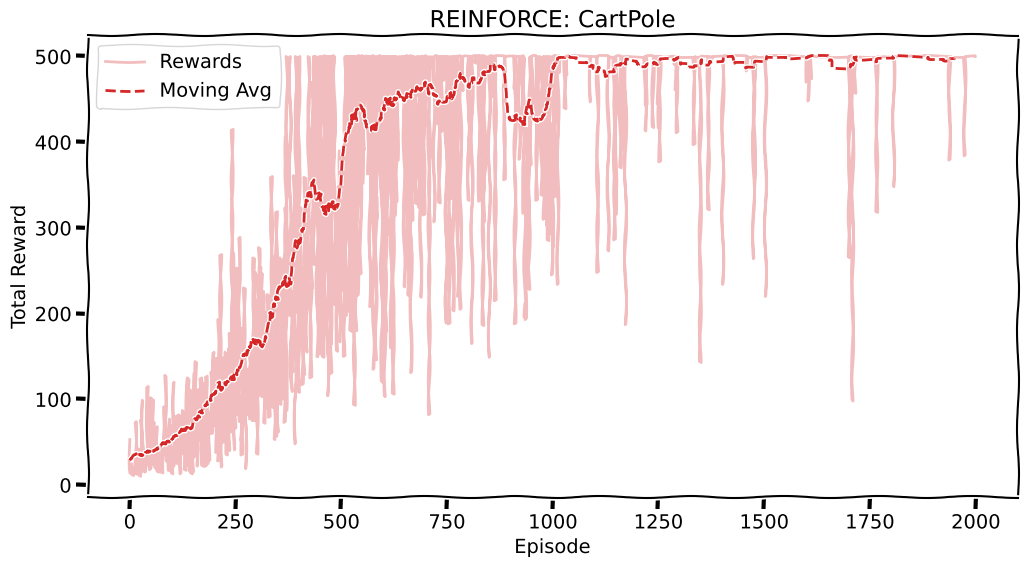

In [21]:
# Plotting Results
window_size = 50  # Moving average window size

# Moving average calculation
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

plt.plot(sum_rewards, label="Rewards", alpha=0.3, color='tab:red')

# Plotting moving averages
plt.plot(moving_average(sum_rewards, window_size), label="Moving Avg", linestyle='--', color='tab:red')

plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.legend()
plt.title("REINFORCE: CartPole")
plt.show()

In [22]:
mean_reward, std_reward = np.mean(sum_rewards), np.std(sum_rewards)
print(f"Mean Reward = {mean_reward:.2f} +/- {std_reward:.4f}")

Mean Reward = 393.62 +/- 168.3092


## Simulation

In [23]:
record_simulation(gym.make("CartPole-v1", render_mode='rgb_array', new_step_api=True), policy.to(DEVICE), "Video_CartPole")